In [ ]:
!pip install transformers

In [1]:
from transformers import AutoImageProcessor, TFViTForImageClassification

In [2]:
import keras
#from transformers import AutoImageProcessor, TFViTForImageClassification
import tensorflow as tf
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:

model = TFViTForImageClassification.from_pretrained(
        'facebook/dino-vitb16',
        num_labels=1,
        ignore_mismatched_sizes=True
    )
model.vit.trainable = False  # Congelar capas base
# model.classifier = tf.keras.layers.Dense(1, activation="sigmoid")


model.summary()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some layers from the model checkpoint at facebook/dino-vitb16 were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 85799425 (327.30 MB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


In [7]:
base_dir = "/content/drive/MyDrive/datos"


datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary",
    subset="validation"
)


Found 1928 images belonging to 2 classes.
Found 481 images belonging to 2 classes.


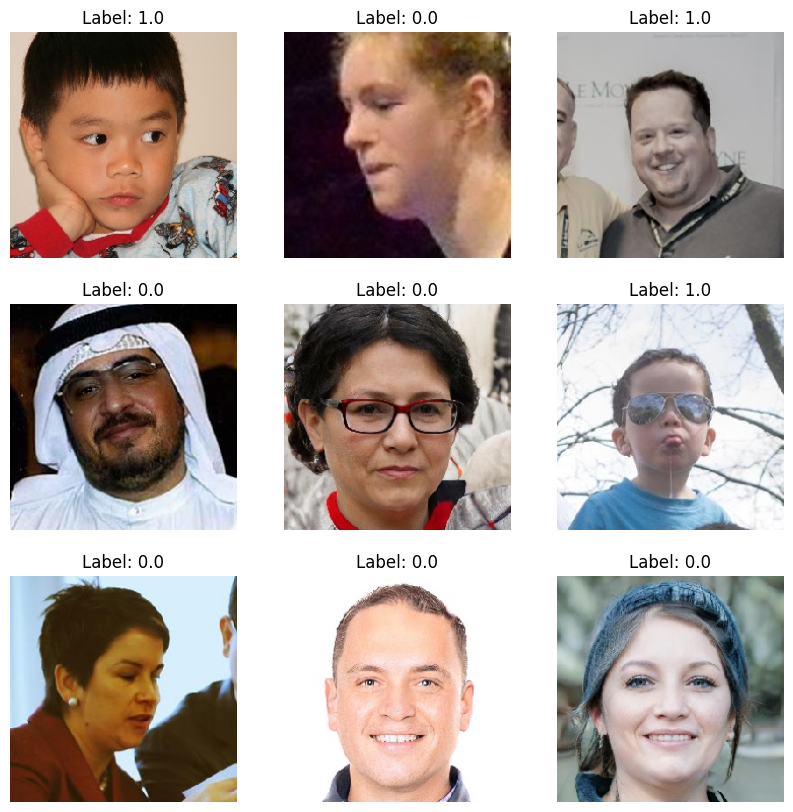

In [8]:
from PIL import Image

# Obtener un lote de imágenes
x_batch, y_batch = next(train_generator)

# Visualizar un par de imágenes del lote
plt.figure(figsize=(10, 10))

for i in range(9):  # Mostrar 9 imágenes
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])  # Mostrar la imagen
    plt.title(f'Label: {y_batch[i]}')  # Etiqueta correspondiente (0 o 1)
    plt.axis('off')

plt.show()


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
class_mapping = train_generator.class_indices
print("Relación entre clases e índices:")
for class_name, class_index in class_mapping.items():
    print(f"Clase: '{class_name}' --> Índice: {class_index}")


Relación entre clases e índices:
Clase: 'fake' --> Índice: 0
Clase: 'real' --> Índice: 1


In [10]:
from transformers import AutoImageProcessor
import numpy as np


image_processor = AutoImageProcessor.from_pretrained('facebook/dino-vitb16', do_rescale=False)


def preprocess_batch(batch):
    images, labels = batch
    pixel_values = image_processor(images=images, return_tensors="tf").pixel_values
    return pixel_values, labels

train_data = map(preprocess_batch, train_generator)
val_data = map(preprocess_batch, val_generator)


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

In [ ]:
pip install --upgrade numpy tensorflow


In [13]:
#opt = Adam(learning_rate=1e-3)
model.compile(
optimizer='adam',
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
metrics=["accuracy"]
)

In [14]:
for batch, labels in train_generator:
    print("Shape del batch de imágenes:", batch.shape)  # Debería ser (batch_size, 224, 224, 3)
    print("Shape de las etiquetas:", labels.shape)      # Debería ser (batch_size,)
    break


Shape del batch de imágenes: (32, 224, 224, 3)
Shape de las etiquetas: (32,)


In [15]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

In [ ]:
from transformers import Trainer, TrainingArguments
#import tensorflow as tf

# Verificar si TensorFlow detecta la GPU
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    # Configurar TensorFlow para usar la primera GPU disponible
    tf.config.set_visible_devices(gpus[0], 'GPU')
    print("GPU está siendo utilizada para entrenamiento.")
else:
    print("No se detectó GPU, utilizando CPU.")


In [ ]:


# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Carpeta para guardar los resultados
    evaluation_strategy="epoch",     # Evaluación por época
    learning_rate=1e-3,              # Tasa de aprendizaje
    per_device_train_batch_size=32,  # Tamaño del lote
    per_device_eval_batch_size=64,   # Tamaño del lote para evaluación
    num_train_epochs=10,             # Número de épocas
    weight_decay=0.01,               # Decaimiento del peso
    report_to="none",                # Evitar reporte en plataformas como WandB
)

# Crear el Trainer
trainer = Trainer(
    model=model,                         # El modelo que se va a entrenar
    args=training_args,                  # Los argumentos de entrenamiento
    train_dataset=train_data,            # El dataset de entrenamiento
    eval_dataset=val_data,               # El dataset de validación
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
trainer.evaluate()


In [16]:
with tf.device('/GPU:0'):  # Asegurar entrenamiento en GPU
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )

Epoch 1/10
19/60 [========>.....................] - ETA: 7:24 - loss: 6.9858 - accuracy: 0.4967

KeyboardInterrupt: 

In [21]:
X_ex = iter(train_data)
x_batch, y_batch = next(X_ex)
y_ex = model.predict(x_batch)

1/1 [==============================] - 2s 2s/step


In [27]:
y_batch

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [28]:
y_ex

TFSequenceClassifierOutput(loss=None, logits=array([[-2.7949066 ],
       [-1.6979221 ],
       [-2.4324517 ],
       [ 0.7229739 ],
       [-0.66833115],
       [-1.7342181 ],
       [-2.1902208 ],
       [-0.7045248 ],
       [-0.54023266],
       [-2.9337256 ],
       [-0.75984836],
       [-3.3747456 ],
       [-2.2984343 ],
       [-0.57010573],
       [-2.5632544 ],
       [-1.6276529 ],
       [-1.2982204 ],
       [-1.7014636 ],
       [-1.2072997 ],
       [-2.9160345 ],
       [-1.1639704 ],
       [-0.57025087],
       [-1.0352302 ],
       [-0.6152768 ],
       [-2.4368575 ],
       [-0.72870386],
       [-1.4359291 ],
       [-1.0601865 ],
       [-2.2719557 ],
       [-2.2790196 ],
       [-2.64669   ],
       [-1.0363339 ]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
# Evaluar el modelo en el conjunto de validación
validation_steps = val_generator.samples // val_generator.batch_size
val_loss, val_accuracy = model.evaluate(val_data,steps=validation_steps)
print(f"Loss en validación: {val_loss}")
print(f"Precisión en validación: {val_accuracy}")


In [ ]:
import matplotlib.pyplot as plt

# Graficar la curva de pérdida
plt.figure(figsize=(12, 6))

# Pérdida en entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (Validación)')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión (Entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión (Validación)')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()
